#### Set up environment

In [2]:
import pickle
import os
import pyabc
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import cm
import pandas as pd
import sys

# Bespoke RAMP classes for running the model
sys.path.append("../../")
# from opencl_runner import OpenCLWrapper  # Some additional functions to simplify running the OpenCL model
from opencl_runner import OpenCLRunner

from pyabc.transition.multivariatenormal import MultivariateNormalTransition  # For drawing from the posterior


#### Read in history.pkl objects

In [4]:
history_dict = {}
windows  =4
n_pops = 10
n_particles = 200
for window in range(1,windows+1):
    fname = "Outputs/New/abc_history_8windows_window{}, 10pops_200particles_Crb0.019_1652367181.pkl".format(window)
    with open(fname, "rb") as f:
            history = pickle.load(f)
    history_dict["w{}".format(window)]= history

#### Read in observations data

In [5]:
# Read in daily devon case data (interpolated from weekly)
cases_devon_daily = pd.read_csv("observation_data/daily_cases_devon.csv")
# Add column with cumulative sums rather than cases per day
cases_devon_daily['CumulativeCases'] = cases_devon_daily['OriginalCases'].cumsum()
# Keep just cumulative cases
cases_devon_daily = cases_devon_daily['CumulativeCases'].values

## Get dataframe with totals for whole of Devon
cases_devon_weekly = pd.read_csv("observation_data/weekly_cases_devon.csv")
# Add column with cumulative sums rather than cases per week
cases_devon_weekly['CumulativeCases'] = cases_devon_weekly['OriginalCases'].cumsum()
# Keep just cumulative cases
cases_devon_weekly = cases_devon_weekly['CumulativeCases'].values

# Convert this interpolated data used in seeding back to weekly
# List the index matching the end day of each week (e.g. 7, 14, 21 etc (minus 1 for indexing starting at 0)
n_days = len(cases_devon_daily)
week_end_days = list(range(6,n_days+1,7))

# Keep only the values from the end of each week
cases_devon_daily_summed_weekly = cases_devon_daily[week_end_days]

#### Define prior parameter values

In [6]:
retail_rv, primary_school_rv, secondary_school_rv = (pyabc.RV("uniform", 0, 1) for _ in range(3))
work_rv = pyabc.RV("beta", 0.1, 2)
presymptomatic_rv, symptomatic_rv, asymptomatic_rv = (pyabc.RV("norm", 0.444, 0.155) for _ in range(3))

# Group all random variables together and give them a string name (this is needed for the distribution later)
all_rv = {"retail": retail_rv, "primary_school": primary_school_rv, "secondary_school": secondary_school_rv, "work": work_rv,
    "presymptomatic": presymptomatic_rv, "symptomatic": symptomatic_rv, "asymptomatic": asymptomatic_rv}

## Create a distrubtion from these random variables
decorated_rvs = {name: pyabc.LowerBoundDecorator(rv, 0.0) for name, rv in all_rv.items()}

# Define the original priors
original_priors = pyabc.Distribution(**decorated_rvs)

### Run model with default parameter values  
This shows what happens with the 'default' (manually calibrated) model.  
These parameters are from the 'optimal' particle in the InitialModelCalibration.ipynb script, in which the model is ran with ABC with ten populations for 133 days.  

In [17]:
## Define parameters
ITERATIONS = 105  # Number of days to run for
assert (ITERATIONS /7).is_integer() # check it is divisible by 7 
NUM_SEED_DAYS = 14  # Number of days to seed the population
USE_GPU = False
STORE_DETAILED_COUNTS = False
REPETITIONS = 5
USE_HEALTHIER_POP = True
PARAMETERS_FILE = os.path.join("../../","model_parameters", "default.yml")
OPENCL_DIR = os.path.join("..", "..", "microsim", "opencl")
SNAPSHOT_FILEPATH = os.path.join(OPENCL_DIR, "snapshots", "cache.npz")

# Think x by 7 because daily data is used in running model?
assert ITERATIONS < len(cases_devon_weekly)*7,     f"Have more iterations ({ITERATIONS}) than observations ({len(cases_devon_weekly)*7})."

# Initialise the class so that its ready to run the model.
OpenCLRunner.init( iterations = ITERATIONS, repetitions = REPETITIONS, observations =  cases_devon_weekly.T,
    use_healthier_pop = USE_HEALTHIER_POP, use_gpu = USE_GPU, store_detailed_counts = STORE_DETAILED_COUNTS,
    parameters_file = PARAMETERS_FILE, opencl_dir = OPENCL_DIR,snapshot_filepath = SNAPSHOT_FILEPATH,
    num_seed_days = NUM_SEED_DAYS)

#These are from InitialModelCalibration.ipynb
best_params_14days = {"asymptomatic":0.270783, "presymptomatic":0.425259, 
                                  "primary_school": 0.671804, "retail": 0.549859, "secondary_school": 0.198538, 
                                  "symptomatic": 0.488184, "work":0.049661}

OpenCLRunner.update(repetitions=5)  # Temporarily use more repetitions to give a good baseline
OpenCLRunner.update(store_detailed_counts=True)  # Temporarily output age breakdowns
(fitness_14days, sim_14days, obs_14days, out_params_14days, summaries_14days) = OpenCLRunner.run_model_with_params_abc(
    best_params_14days, return_full_details=True, quiet = False)
OpenCLRunner.update(repetitions=REPETITIONS)
OpenCLRunner.update(store_detailed_counts=STORE_DETAILED_COUNTS)


# These are from InitialModelCalibration.ipynb
best_params_133days = {"asymptomatic":0.411005, "presymptomatic":0.371609, 
                                  "primary_school": 0.609788, "retail": 0.640238, "secondary_school": 0.536117, 
                                  "symptomatic": 0.737517, "work":0.008547}

OpenCLRunner.update(repetitions=5)  # Temporarily use more repetitions to give a good baseline
OpenCLRunner.update(store_detailed_counts=True)  # Temporarily output age breakdowns
(fitness_133days, sim_133days, obs_133days, out_params_133days, summaries_133days) = OpenCLRunner.run_model_with_params_abc(
    best_params_133days, return_full_details=True, quiet = False)
OpenCLRunner.update(repetitions=REPETITIONS)
OpenCLRunner.update(store_detailed_counts=STORE_DETAILED_COUNTS)

Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [02:58<00:00, 35.62s/it]


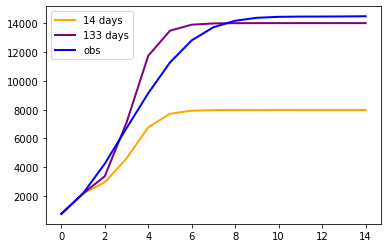

In [19]:
# Plot
fig, ax = plt.subplots(1,1)
x = range(len(sim_14days))
ax.plot(x, sim_14days, label="14 days", color="orange", linewidth=2)
ax.plot(x, sim_133days, label="133 days", color="purple", linewidth=2)
ax.plot(range(len(cases_devon_daily_summed_weekly[0:(int(ITERATIONS/7))])), 
       cases_devon_daily_summed_weekly[0:(int(ITERATIONS/7))], label="obs", color="blue", linewidth=2)
ax.legend()

#### Assess how parameter values change over time with dynamic calibration

C:\ProgramData\Anaconda3\envs\ramp-ua-min\lib\site-packages\ipykernel_launcher.py:38: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.


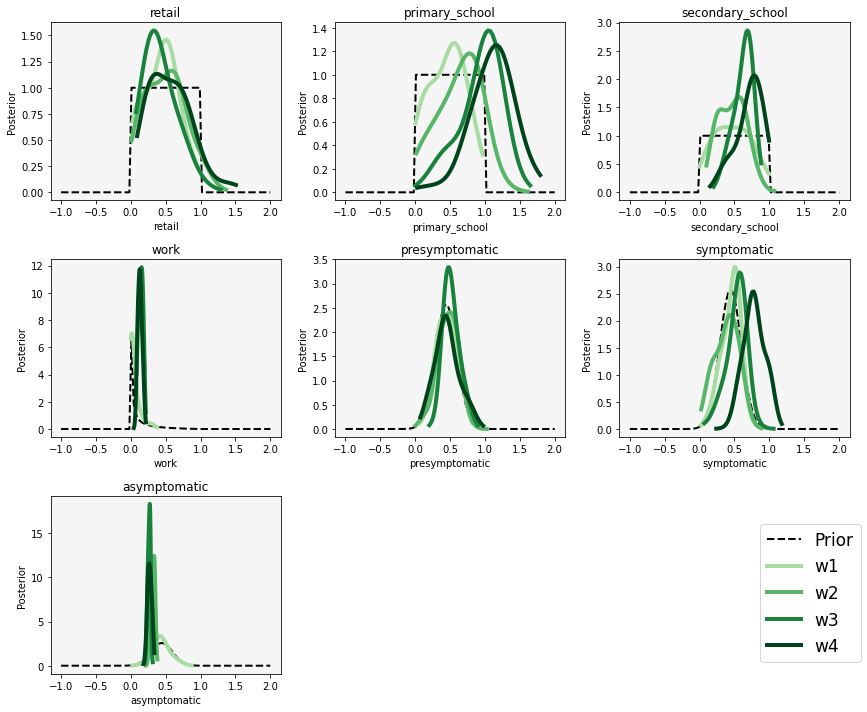

In [9]:
# define colour map
evenly_spaced_interval = np.linspace(0.35, 1, len(history_dict))
colors = [cm.Greens(x) for x in evenly_spaced_interval]
# colors =  ['lightcyan', 'paleturquoise', 'darkturquoise', 'teal', 'midnight ']

fig, axes = plt.subplots(3,int(len(original_priors)/2), figsize=(12,10))
for i, param in enumerate(original_priors.keys()):
    color_i =0
    ax = axes.flat[i]
    ax.set_facecolor('whitesmoke')
    # Add parameter priors
    priors_x = np.linspace(-1, 2, 99)  # (specified so that we have some whole numbers)
    ax.plot(priors_x, pyabc.Distribution(param=all_rv[param]).pdf({"param": priors_x}), 
            color = 'black', label = 'Prior', linewidth  = 2, linestyle ='dashed')
    for history_name, history in history_dict.items():
        color = colors[color_i]
        df, w = history.get_distribution(m=0, t=history.max_t)
        pyabc.visualization.plot_kde_1d(df, w, x=param, ax=ax,
                label=history_name, linewidth = 4,
                color= color)
        ax.legend(fontsize="small")
        ax.set_title(f"{param}")
        handles, labels = ax.get_legend_handles_labels()
        ax.get_legend().remove()
        color_i = color_i +1
#     if param!="work":
#             ax.set_xlim(-0.5,1.5)        
#     if param=="work":
#         ax.set_xlim(-0.05,0.1)
#     if param =='asymptomatic':
#           ax.set_xlim(-0.05,0.1)    
fig.legend(handles, labels, loc='center right', fontsize = 17,
            bbox_to_anchor=(1.01, 0.17))
          # ncol = 8, bbox_to_anchor=(0.5, -0.07))
axes[2,2].set_axis_off()
axes[2,1].set_axis_off()
fig.tight_layout()
fig.show()
# fig.savefig("Plots/8windows_14days_each_finalpop.jpg")

#### Parameter values for all populations for each window

C:\ProgramData\Anaconda3\envs\ramp-ua-min\lib\site-packages\ipykernel_launcher.py:38: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.


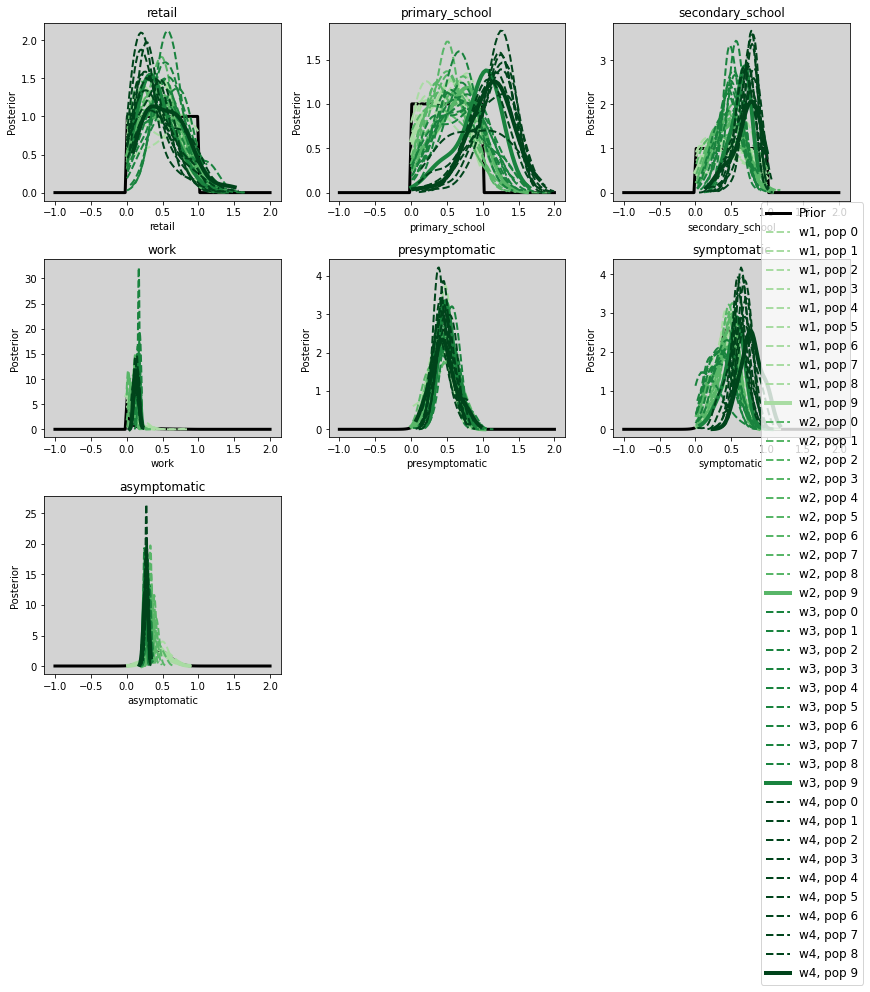

In [10]:
# define colour map and line style to use in intermediate populations
linestyles = ['dashed'] * history.max_t + ['solid']
linewidths = [2] * history.max_t + [4]

# Set up plot
fig, axes = plt.subplots(3,int(len(original_priors)/2), figsize=(12,10))
for i, param in enumerate(original_priors.keys()):
    color_i =0
    ax = axes.flat[i]
    ax.set_facecolor('lightgray')
    # Add parameter priors
    priors_x = np.linspace(-1, 2, 99)  # (specified so that we have some whole numbers)
    ax.plot(priors_x, pyabc.Distribution(param=all_rv[param]).pdf({"param": priors_x}), 
            color = 'black', label = 'Prior', linewidth  = 3, linestyle ='solid')
    for history_name, history in history_dict.items():
        color = colors[color_i]
        for t in range(history.max_t + 1):
            df, w = history.get_distribution(m=0, t=t)
            pyabc.visualization.plot_kde_1d(df, w, x=param, ax=ax,
                label="{}, pop {}".format(history_name, t),
                color = color, linestyle = linestyles[t],linewidth = linewidths[t])
            ax.legend(fontsize="small")
            ax.set_title(f"{param}")
            handles, labels = ax.get_legend_handles_labels()
            ax.get_legend().remove()
        color_i = color_i +1
#     if param!="work":
#             ax.set_xlim(-0.5,1.5)        
#     if param=="work":
#         ax.set_xlim(-0.05,0.1)
#     if param =='asymptomatic':
#           ax.set_xlim(-0.05,0.1)    
fig.legend(handles, labels, loc='center right', fontsize = 12,
            bbox_to_anchor=(1.01, 0.17))
axes[2,2].set_axis_off()
axes[2,1].set_axis_off()
fig.tight_layout()
fig.show()

### Plot just the first window to allow comparison of the evolution of each population between this and running the model with more populations (/less windows)

C:\ProgramData\Anaconda3\envs\ramp-ua-min\lib\site-packages\ipykernel_launcher.py:35: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.


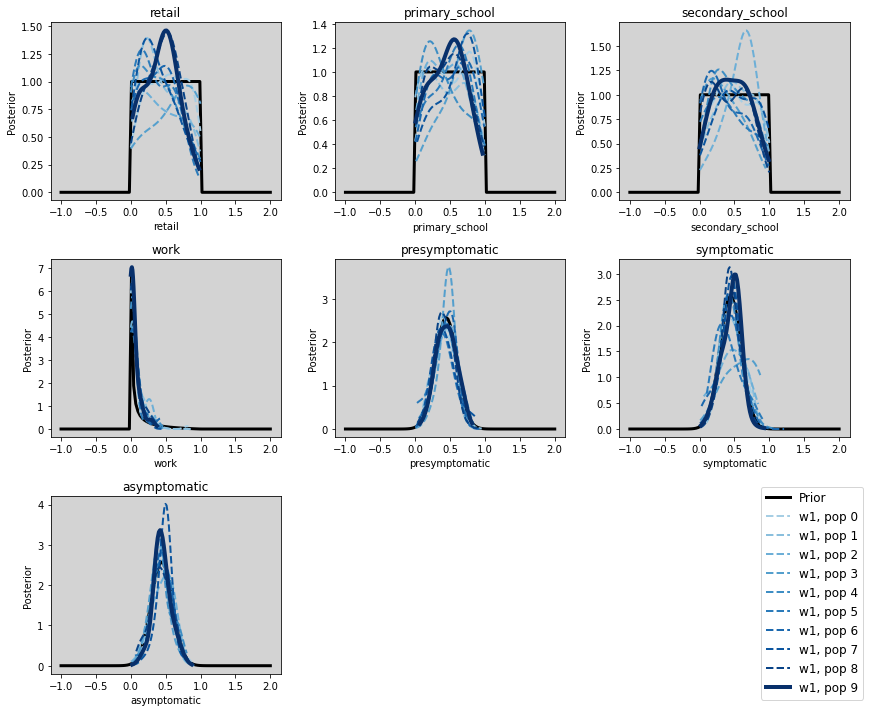

In [12]:
# define colour map and line style to use in intermediate populations
evenly_spaced_interval = np.linspace(0.35, 1, n_pops)
colors = [cm.Blues(x) for x in evenly_spaced_interval]
linestyles = ['dashed'] * history.max_t + ['solid']
linewidths = [2] * history.max_t + [4]

# Set up plot
fig, axes = plt.subplots(3,int(len(original_priors)/2), figsize=(12,10))
for i, param in enumerate(original_priors.keys()):
    color_i =0
    ax = axes.flat[i]
    ax.set_facecolor('lightgray')
    # Add parameter priors
    priors_x = np.linspace(-1, 2, 99)  # (specified so that we have some whole numbers)
    ax.plot(priors_x, pyabc.Distribution(param=all_rv[param]).pdf({"param": priors_x}), 
            color = 'black', label = 'Prior', linewidth  = 3, linestyle ='solid')
    history_name = 'w1'
    history = history_dict['w1']
    #for history_name, history in history_dict.items():
    for t in range(history.max_t + 1):
        color = colors[t]
        df, w = history.get_distribution(m=0, t=t)
        pyabc.visualization.plot_kde_1d(df, w, x=param, ax=ax,
            label="{}, pop {}".format(history_name, t),
            color = color, linestyle = linestyles[t],linewidth = linewidths[t])
        ax.legend(fontsize="small")
        ax.set_title(f"{param}")
        handles, labels = ax.get_legend_handles_labels()
        ax.get_legend().remove() 
fig.legend(handles, labels, loc='center right', fontsize = 12,
            bbox_to_anchor=(1.01, 0.17))
axes[2,2].set_axis_off()
axes[2,1].set_axis_off()
fig.tight_layout()
fig.show()

### Get the model predictions and particle distances for each particle within each dynamic calibration window. Store these in a dictionary

In [13]:
# Create dictionary linking each window name to its length (days)
window_lengths_dict = {}
for count, key in enumerate(history_dict.keys()):
    window_lengths_dict[key]=14*(count+1)

# Create dictionary to store results for each window
abc_sum_stats = {}

# Loop through each calibration window, defining the number of days it covered
for t in range(0,history.n_populations):
    print(t)
    for window, n_days in window_lengths_dict.items():

        # Create lists to store values for each particle
        distance_l, daily_preds_l, params_l = [],[],[]

        # get the history for this window    
        history_wx  = history_dict[window]   

        # Get parameter values
        parameter_vals_df, w = history_wx.get_distribution(m=0, t=t)

        # Get the summary stats for the final population for this window ([1] means keep just the 
        # dataframe and not the array of weights)
        weighted_sum_stats_t0 = history_wx.get_weighted_sum_stats_for_model(t=t)[1]
     
        # Loop through each particle and save their distance and predictions into the lists
        for particle_no in range(0,100):
            # Get data for just this particle
            particle_x_dict = weighted_sum_stats_t0[particle_no]

            # Get daily predictions
            cumulative_model_diseased_devon = particle_x_dict["model_daily_cumulative_infections"]     
            cumulative_model_diseased_devon = cumulative_model_diseased_devon[0:n_days]

            # Add daily predictions for this particle to list
            daily_preds_l.append(cumulative_model_diseased_devon)

            # Add distance to list
            distance_l.append(particle_x_dict['distance'])

            # Add parameter values to list
            params_l.append(parameter_vals_df.iloc[particle_no])

        # Add to dictionary for this window
        abc_sum_stats["{}_{}".format(window,t)] = {'distance_l':distance_l, 'daily_preds_l' :daily_preds_l, 'params_l':params_l}

0
1
2
3
4
5
6
7
8
9


#### Compare model predictions from dynamically calibrated model (from within calibration window) against observations
For each window, plot the predictions made by each particle in the final population 


Text(0.5, 0.98, 'Number of infections predicted by each particle within each window - final population')

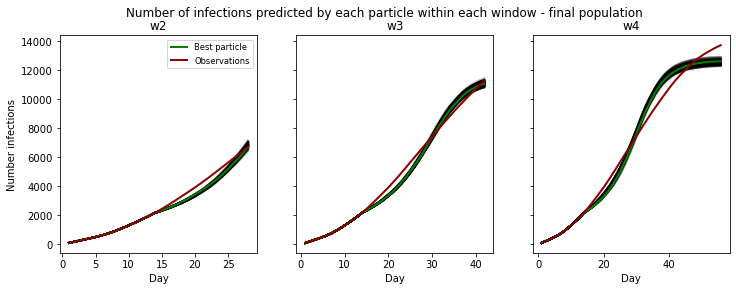

In [14]:
# Create figure
fig, axes = plt.subplots(1, len(window_lengths_dict)-1, figsize=(12,4), sharey = True)

# Create dictionary containing all items except the first item
# This is because the first window is length 14, and the model is seeded for 14 days
# thus the results are identical and the code fails 
windows_length_dict_w2_onwards = dict(list(window_lengths_dict.items())[1:])

for axes_number, (window, n_days)  in enumerate(windows_length_dict_w2_onwards.items()):
    # Define t (the last timeslice in the window)
    t = history.max_t
    # Find the best particle
    best_particle_idx = abc_sum_stats["{}_{}".format(window,t)]['distance_l'].index(min(abc_sum_stats["{}_{}".format(window,t)]['distance_l']))

    # Get data for this window
    daily_preds_l  = abc_sum_stats["{}_{}".format(window,t)]['daily_preds_l']   
    distance_l = abc_sum_stats["{}_{}".format(window,t)]['distance_l']   

    # Normalise distance to 0-1 to calculate transparency
    _distance = np.array(distance_l)  # Easier to do maths on np.array
    distance_norm = (_distance - min(_distance)) / (max(_distance) - min(_distance))

    # Define x axis for plot (number of days these results relate to)
    x=range(1,n_days+1)    

    # For each particle, plot the predictions, coloured by distance
    for i in range(0,len(daily_preds_l)):
        axes[axes_number].plot(x, daily_preds_l[i], color="black", linewidth = 2, alpha=1-distance_norm[i])  # (1-x because high distance is bad)

    # Add the best particle
    axes[axes_number].plot(x, daily_preds_l[best_particle_idx], color="green", linewidth = 2,
                          label = 'Best particle')  # (1-x because high distance is bad)

    # Add observations
    axes[axes_number].plot(x, cases_devon_daily[0:len(daily_preds_l[0])], label="Observations",
                            linewidth = 2, color="darkred")

    # Apply labels
    axes[axes_number].set_xlabel("Day")
    axes[axes_number].set_title("{}".format(window))

# Apply legend
axes[0].legend(fontsize="small")
axes[0].set_ylabel("Number infections")

# Set full plot title
fig.suptitle('Number of infections predicted by each particle within each window - final population'.format(t))


#### Compare model predictions from dynamically calibrated model (from within calibration window) against observations
For the final window, plot the predictions made by each particle in each population

Text(0.5, 0.98, 'Number of infections predicted by each particle within each population in the final window ')

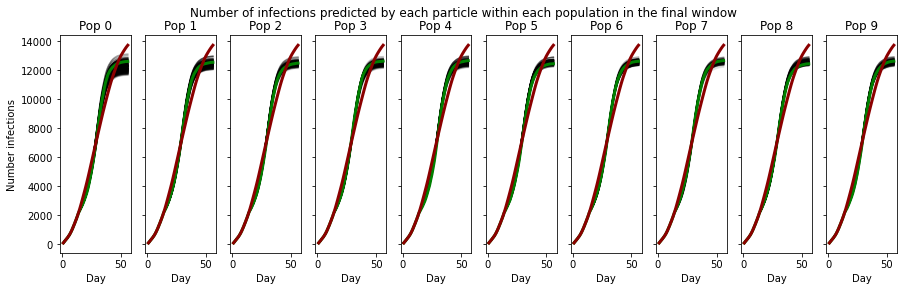

In [15]:
# Create figure
fig, axes = plt.subplots(1, history.max_t+1, figsize=(15,4), sharey=True)
for axes_number, t in enumerate(range(0, history.max_t+1)):
    # Create dictionary containing all items except the first item
    window, n_days = list(window_lengths_dict.items())[-1]
    
    # Find the best particle
    best_particle_idx = abc_sum_stats["{}_{}".format(window,t)]['distance_l'].index(min(abc_sum_stats["{}_{}".format(window,t)]['distance_l']))

    # Get data for this window
    daily_preds_l  = abc_sum_stats["{}_{}".format(window,t)]['daily_preds_l']   
    distance_l = abc_sum_stats["{}_{}".format(window,t)]['distance_l']   

    # Normalise distance to 0-1 to calculate transparency
    _distance = np.array(distance_l)  # Easier to do maths on np.array
    distance_norm = (_distance - min(_distance)) / (max(_distance) - min(_distance))

    # define number of days these results relate to
    x=range(1,n_days+1)    

    # For each particle, plot the predictions, coloured by distance
    for i in range(0,len(daily_preds_l)):
        axes[axes_number].plot(x, daily_preds_l[i], color="black", alpha=1-distance_norm[i])  # (1-x because high distance is bad)

    # Add the best particle
    axes[axes_number].plot(x, daily_preds_l[best_particle_idx], color="green", linewidth = 3,
                          label = 'Best particle')  # (1-x because high distance is bad)

    # Add observations
    axes[axes_number].plot(x, cases_devon_daily[0:len(daily_preds_l[0])], label="Observations",
                            linewidth = 3, color="darkred")

    # Apply labels
    axes[axes_number].set_xlabel("Day")
    axes[axes_number].set_title("Pop {}".format(t))

axes[0].set_ylabel("Number infections")
# Apply legend
# axes[0].legend(fontsize="large")
    
# Set full plot title
fig.suptitle('Number of infections predicted by each particle within each population in the final window '.format(t))

#### Model predictions for future

In [20]:
##### Set up OpenCL runner
# Define filepath to file containing default parameter values
PARAMETERS_FILE = os.path.join("../../","model_parameters", "default.yml")
PARAMS = OpenCLRunner.create_parameters(parameters_file=PARAMETERS_FILE)

# Optionally initialise the population, delete the old OpenCL model snapshot (i.e. an already-initialised model) and
# re-create a new one. Useful if something may have changed (e.g. changed the lockdown file).
OPENCL_DIR = os.path.join("..", "..", "microsim", "opencl")
SNAPSHOT_FILEPATH = os.path.join(OPENCL_DIR, "snapshots", "cache.npz")
assert os.path.isfile(SNAPSHOT_FILEPATH), f"Snapshot doesn't exist: {SNAPSHOT_FILEPATH}"

# Initialise the class so that its ready to run the model.
OpenCLRunner.init(iterations = 105,  repetitions = 5,observations = cases_devon_weekly, use_healthier_pop = True, 
    use_gpu = False, store_detailed_counts = False, parameters_file = PARAMETERS_FILE,opencl_dir = OPENCL_DIR,
    snapshot_filepath = SNAPSHOT_FILEPATH,num_seed_days = 14) 
# Set constants 
current_risk_beta_val =0.019
const_params_dict = { "current_risk_beta": current_risk_beta_val,"home": 1.0}
OpenCLRunner.set_constants(const_params_dict)

# Use parameters from dynamic calibration process to run model for 105 days
# Define the number of samples to take from the posterior distribution of parameters
N_samples = 30

# Create dictionary to store results for each window
windows_dict ={}

for window in window_lengths_dict.keys():

    # Define abc_history object from final window
    abc_history = history_dict[window]

    # Get dataframe of posterior parameter values
    df, w = abc_history.get_distribution(m=0, t=abc_history.max_t)

    # Sample from the dataframe of posteriors using KDE
    kde = MultivariateNormalTransition(scaling=1)
    kde.fit(df, w)
    samples = kde.rvs(N_samples)

    # Now run N models and store the results of each one
    distance_l, sim_l, obs_l, out_params_l,out_calibrated_params_l, summaries_l = [],[],[],[],[],[] 

    negative_count = 0  # Count the number of negatives returned in the KDE posterior
    for i, sample in samples.iterrows():
        # Check for negatives. If needed, resample
        while (sample < 0).values.any():
            #print("Found negatives. Resampling")
            negative_count += 1
            sample = kde.rvs()
            # Added in this line as the sample was in the wrong format for the while loop
            sample = pd.Series(sample)

        # Create a dictionary with the parameters and their values for this sample
        param_values = sample.to_dict()
        #print(param_values)

        # _summaries = 
        (_distance, _sim, _obs, _out_params, _summaries) =             OpenCLRunner.run_model_with_params_abc(param_values, return_full_details=True)
        #print(f"distance: {_distance}.")

        distance_l.append(_distance)
        sim_l.append(_sim)
        obs_l.append(_obs)
        out_params_l.append(_out_params)
        out_calibrated_params_l.append(param_values)
        summaries_l.append(_summaries)

    print(f"Finished sampling. Ignored {negative_count} negative samples.")

    # add to dictionary
    windows_dict[window] = {'distance': distance_l, 'sim': sim_l, 'obs':obs_l, 'summaries': summaries_l, 
                            'out_calibrated_params': out_calibrated_params_l, 'out_params': out_params_l}



Finished sampling. Ignored 30 negative samples.
Finished sampling. Ignored 9 negative samples.
Finished sampling. Ignored 4 negative samples.
Finished sampling. Ignored 0 negative samples.


#### Plot the individual results for each sample and compare to observations

/nfs/a321/gy17m2a/anaconda_install/anaconda3/envs/ramp-ua-min/lib/python3.7/site-packages/IPython/core/pylabtools.py:132: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or axes decorations smaller.
  fig.canvas.print_figure(bytes_io, **kw)


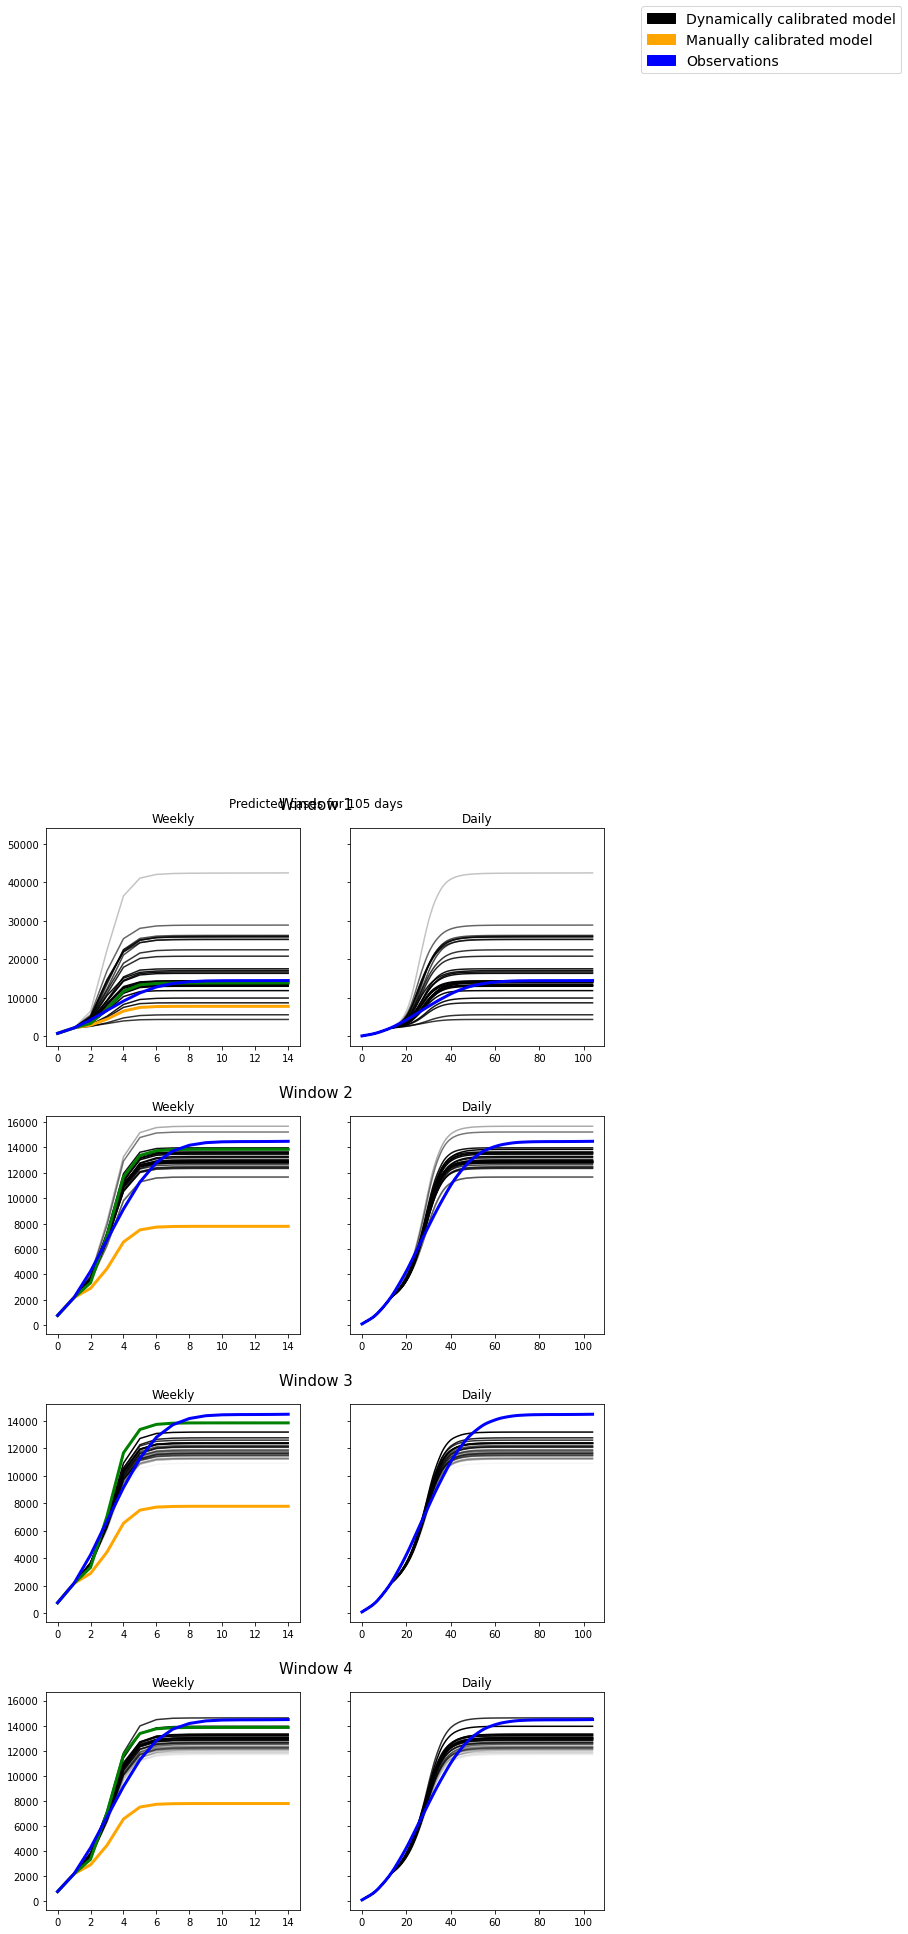

In [30]:
windows= list(window_lengths_dict.keys())

# create 3x1 subplots
fig, axs = plt.subplots(nrows=len(windows_dict), ncols=1, constrained_layout=True, figsize = (10,16))
fig.suptitle('Predicted cases for 105 days')

# clear subplots
for ax in axs:
    ax.remove()

# add subfigure per subplot
gridspec = axs[0].get_subplotspec().get_gridspec()
subfigs = [fig.add_subfigure(gs) for gs in gridspec]

windows_i = 0
for row, subfig in enumerate(subfigs):
    subfig.suptitle('Window {}'.format(row+1), fontsize = 15)
    this_windows_dict = windows_dict[windows[windows_i]]
    # create 1x3 subplots per subfig
    axs = subfig.subplots(nrows=1, ncols=2, sharey= True)
    for col, ax in enumerate(axs):
        
        # Plot model values
        _distance = np.array(this_windows_dict['distance'])  # Easier to do maths on np.array
        distance_norm = (_distance - min(_distance)) / (max(_distance) - min(_distance))
        
        # Plot observations
        if col == 0:
            x = range(len(this_windows_dict['sim'][0]))
            for i in range(len(this_windows_dict['summaries'])):
                ax.plot(x, this_windows_dict['sim'][i],
                color="black", alpha=1 - distance_norm[i]) # (1-x because high distance is bad)
            ax.plot(x, sim_14days, label="sim", color="orange", linewidth = 3)     
            ax.plot(x, sim_133days, label="sim", color="green", linewidth = 3)     
            ax.plot(x, cases_devon_daily_summed_weekly[0:int((105/7))], label="Observations", linewidth=3, color="blue")
            ax.set_title('Weekly')    
        elif col ==1:
            x = range(len(OpenCLRunner.get_cumulative_daily_infections(this_windows_dict['summaries'][1])))
            for i in range(len(this_windows_dict['summaries'])):
                ax.plot(x, OpenCLRunner.get_cumulative_daily_infections(this_windows_dict['summaries'][i]),
                color="black", alpha=1 - distance_norm[i]) # (1-x because high distance is bad)
            #ax.plot(x, sim_manualcalibration, label="sim", color="orange")
            ax.plot(x, cases_devon_daily[0:105], label="Observations", linewidth = 3, color="blue")
            ax.set_title('Daily')
    
    # move on to next window
    windows_i = windows_i+1
    
import matplotlib.patches as mpatches    
black_patch = mpatches.Patch(color='black', label='Dynamically calibrated model')
blue_patch = mpatches.Patch(color='blue', label='Observations')
orange_patch = mpatches.Patch(color='orange', label='Manually calibrated model')
plt.legend(handles=[black_patch, orange_patch, blue_patch], loc="right", fontsize= 14, bbox_to_anchor=(2.2, 8.6))        

#### Run model with single 'best' estimate of parameter values 

In [31]:
#Find the sample drawn from the posterior distribution which has the smallest distance (best performing!)

# Find the index of the lowest distance value
best_params_dict = {}
best_sim_dict = {}

for window in windows_dict.keys():
    # Find the index of the lowest distance value
    best_model_idx = np.argmin(windows_dict[window]['distance'])
    # Find the corresponding parameter values
    best_params = windows_dict[window]['out_calibrated_params'][best_model_idx]

    ## Run model with these best parameters
    OpenCLRunner.update(store_detailed_counts=True)  # Temporarily output age breakdowns
    (distance_bestparams, sim_bestparams, obs_bestparams, out_params_bestparams, summaries_bestparams) = OpenCLRunner.run_model_with_params_abc(
        best_params, return_full_details=True, quiet = True)
    OpenCLRunner.update(store_detailed_counts=False)

    # Add to dictionary
    best_params_dict['{}'.format(window)]= best_params
    best_sim_dict['{}'.format(window)] = sim_bestparams


#### See how the parameters from the particle with the lowest distance relate to the marginal posteriors

/nfs/a321/gy17m2a/anaconda_install/anaconda3/envs/ramp-ua-min/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


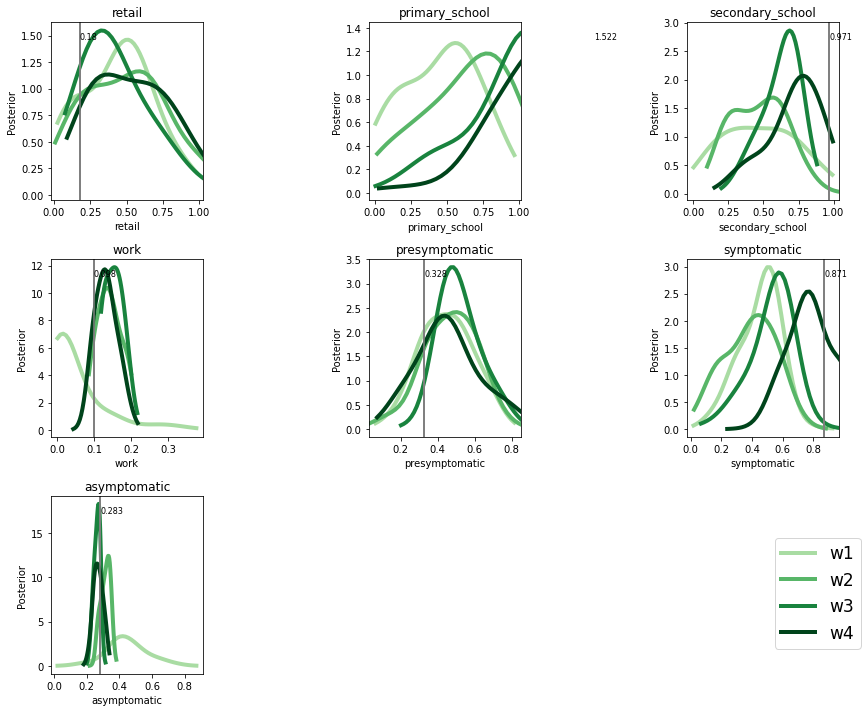

In [32]:
# define colour map
evenly_spaced_interval = np.linspace(0.35, 1, len(history_dict))
colors = [cm.Greens(x) for x in evenly_spaced_interval]

fig, axes = plt.subplots(3,int(len(original_priors)/2), figsize=(12,10))
for i, param in enumerate(original_priors.keys()):
    color_i =0
    ax = axes.flat[i]  
    for history_name, history in history_dict.items():
        color = colors[color_i]
        df, w = history.get_distribution(m=0, t=history.max_t)
        pyabc.visualization.plot_kde_1d(df, w, x=param, ax=ax,
                label=history_name, linewidth = 4,
                color= color)
        ax.legend(fontsize="small")
        ax.set_title(f"{param}")
        handles, labels = ax.get_legend_handles_labels()
        ax.get_legend().remove()
        color_i = color_i +1
        ax.axvline(x=best_params[param], color="grey", linestyle="solid")
    ax.text(x=best_params[param], y=0.9*ax.get_ylim()[1], s=str(round(best_params[param],3)), fontsize=8)
    ax.set_title(f"{param}")    
fig.legend(handles, labels, loc='center right', fontsize = 17,
            bbox_to_anchor=(1.01, 0.17))
          # ncol = 8, bbox_to_anchor=(0.5, -0.07))
axes[2,2].set_axis_off()
axes[2,1].set_axis_off()
fig.tight_layout()
fig.show()
# fig.savefig("Plots/8windows_14days_each_finalpop.jpg")


#### Run model with 'best' parameter values

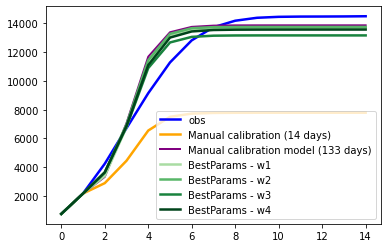

In [40]:
evenly_spaced_interval = np.linspace(0.35, 1, len(history_dict))
colors = [cm.Greens(x) for x in evenly_spaced_interval]
ITERATIONS = 105
fig, ax = plt.subplots(1,1)

# ax.plot(x, sim_manualcalibration, label="manual_calibration", color="green")
ax.plot(range(len(cases_devon_daily_summed_weekly[0:(int(ITERATIONS/7))])), 
       cases_devon_daily_summed_weekly[0:(int(ITERATIONS/7))], label="obs", color="blue", linewidth=2.5)

ax.plot(range(len(sim_14days)), sim_14days, label="Manual calibration (14 days)", color="orange", linewidth =2.5)
ax.plot(range(len(sim_133days)), sim_133days, label="Manual calibration model (133 days)", color="purple", linewidth=2)
        
for num, window in enumerate(windows_dict.keys()):
    best_sim = best_sim_dict["{}".format(window)]
    col = colors[num]
    #Add to plot
    ax.plot(range(len(best_sim)), best_sim, label="BestParams - {}".format(window), color=col,
          linestyle='solid', linewidth =2.5)
    ax.legend()


In [20]:
###############################################################################
###############################################################################
# Compare spatial distribution
# Can't do this currently as OpenCLRunner doesn't return a breakdown by MSOA
###############################################################################
###############################################################################


###############################################################################
###############################################################################
# Save/pickle
###############################################################################
###############################################################################
# fname = "2windows_7seeds_OldDistance_abc.pkl"
# with open( fname, "wb" ) as f:
#         pickle.dump( history, f)